<center><span style="font-size:25px;">СЕГМЕНТАЦИЯ КЛИЕНТОВ ТОРГОВОГО ЦЕНТРА</span></center>

К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В файле содержится основная информация о покупателе: 
* `идентификатор`, 
* `возраст`, 
* `пол`, 
* `доход`, 
* `индекс расходов` (коэффициент покупательской способности). Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

Также в файле содержится информация об истинных метках кластеров для клиентов (они нам пригодятся позже).

<h2 id='contents'>Оглавляшка:</h2>

* [Загружаемые библиотеки](#libs)
* [Загрузка данных и небольшие преобразования признаков](#littlefe)
* [Визуализация данных](#coloredclustfunc) + фуннкция
* [Кластеризация с помощью DBSCAN](#dbscantry) Тут находится Х
* [Агломеративная кластеризация](#dendrogramm) AgglomerativeClustering
    * [График силуэта](#silhouettegraph)
    * [Проверка метрикой](#choosemetric)
* [K-Means кластеризация](#kmeansclust)

## Загружаемые библиотеки <a id='libs'></a>

In [1]:
from data.functions_akialema import *

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import completeness_score, homogeneity_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline
plt.style.use('seaborn-v0_8')

## Загрузка данных и небольшие преобразования признаков<a id='littlefe'></a>

[↑ contents](#contents)

В ходе работы мы подготовим датасет, попробуем несколько видов кластеризации и оценим её качество.

Начнём с просмотра датасета, проведём предобработку данных: удалим пропуски и дубли, признак `Gender` превратим в бинарный.

In [2]:
# Загрузка данных.
cust_df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1-nq4kfWN99zlrmlhqV03kwkptMXgNg7q')
my_info(cust_df)

memory usage: 21.1 KB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,Gender,2,object,Female,205,0,0,see type column
1,cluster,6,float64,0.0,205,4,0,min...: 0.00max..: 5.00mean: 2.23std....: 1.82
2,Age,52,float64,32.0,205,2,0,min...: 18.00max..: 80.00mean: 38.92std....: 14.23
3,Annual Income (k$),66,float64,54.0,205,2,0,min...: 9.00max..: 137.00mean: 60.41std....: 26.91
4,Spending Score (1-100),86,float64,42.0,205,1,0,min...: 1.00max..: 120.00mean: 50.49std....: 26.21
5,CustomerID,205,int64,1,205,0,0,min...: 1.00max..: 205.00mean: 103.00std....: 59.32


In [3]:
# Переименование столбцов.
cust_df.columns = [i.lower().split('(')[0].strip().replace(' ', '_') for i in cust_df.columns]
# Избавление от пустых данных и от неинформативных столбцов.
cust_df = cust_df.dropna()
cust_df = cust_df.drop(columns='customerid')
# Кодирование категориального столбца.
cust_df['gender'] = cust_df['gender'].map({'Male': 1, 'Female': 0})

cust_df.head(5)

,gender,age,annual_income,spending_score,cluster
0,1,19.0,15.0,39.0,4.0
1,1,21.0,15.0,81.0,3.0
2,0,20.0,16.0,6.0,4.0
3,0,23.0,16.0,77.0,3.0
4,0,31.0,17.0,40.0,4.0


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: 
* `годовой заработок`, 
* `коэффициент покупательской способности` и 
* `возраст`.  

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого `функцию`. Она будет принимать: 
* `датафрейм`, 
* `список необходимых столбцов` и 
* `название столбца датафрейма с результатами кластеризации`.  

Визуализируем распределение данных:

[↑ contents](#contents)

<h3 id='coloredclustfunc'>Визуализация данных</h3>

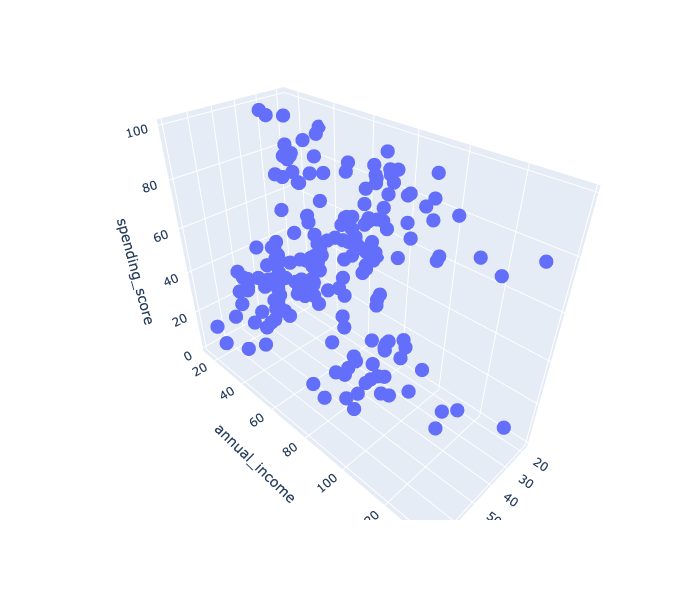

In [4]:
def get_3d_visualization(df, columns=None, clust_res=None):
    
    if not columns:
        columns = df.columns
    
    fig = px.scatter_3d(data_frame=df, color=clust_res, height=600, width=700,
                        x=columns[0], y=columns[1], z=columns[2])
    return fig

get_3d_visualization(cust_df, ['age', 'annual_income', 'spending_score']).show('png')

[↑ contents](#contents)

<h3 id='dbscantry'>Кластеризация с помощью DBSCAN</h3>

Как мы видим, данные разрежённые и неоднородные, а значит, применять `DBSCAN` будет сложно, нужно будет подбирать параметры для кластеризации.

Сохраним признаки, по которым будем проводить моделирование, в переменную `X`:

In [5]:
X = cust_df[['age', 'annual_income', 'spending_score']]
X_scaled = StandardScaler().fit_transform(X)

pd.Series(DBSCAN().fit_predict(X)).value_counts()

-1    200
Name: count, dtype: int64

Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию.  
`Сколько кластеров у вас получилось?`

Ответ: 1

Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, тем большее значение радиуса вокруг точки (eps) нужно задавать. Так как данные разрежённые, попробуем увеличить значение `eps` до 11 и визуально оценим результат:

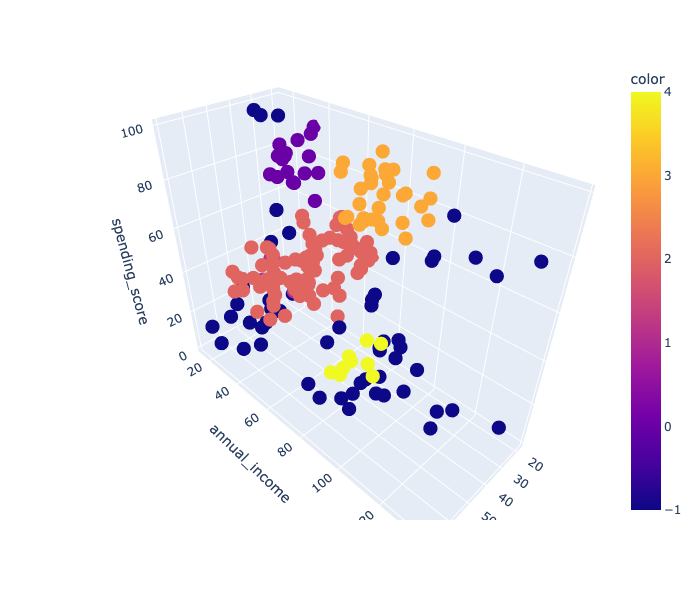

In [6]:
get_3d_visualization(X, clust_res=DBSCAN(eps=11).fit_predict(X)).show('png')

`Подходит ли, по-вашему, алгоритм DBSCAN для решения поставленной задачи?`

Ответ: нет.

Распределение данных неоднородно: в одной области они имеют высокую плотность, в другой области — разряжены. Такие данные не подходят для успешной кластеризации алгоритмом DBSCAN.

`По каким признакам вы оценили качество алгоритма?`

Ответ: Много точек, которые должны относиться к кластеру, были размечены как выбросы (синие точки). 

Такое происходит потому, что данные неоднородны: в некоторых областях они разряжены, а в других имеют большую плотность. Поэтому данный способ, основанный на плотности, не очень подходит для кластеризации.

[↑ contents](#contents)

<h3 id='dendrogramm'>Агломеративная кластеризация</h3>

Построим дендрограмму по аггломеративной кластеризации, чтобы по ней оценить количество кластеров, на которые можно разделить датасет.  
Количество кластеров для кластеризации укажем равным 3 (на данном этапе это не очень важно).

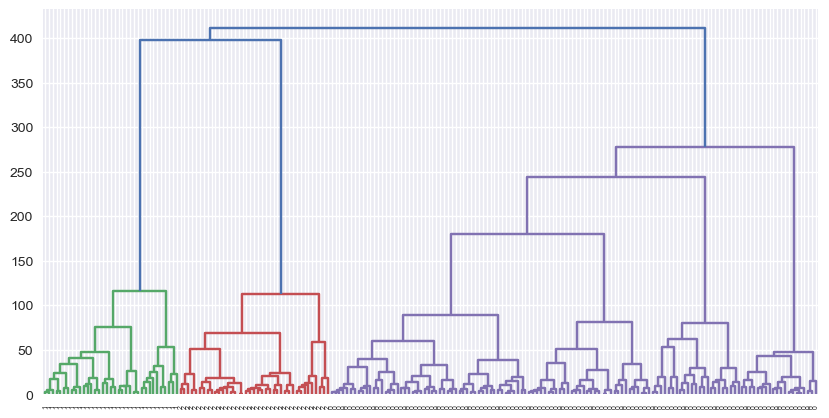

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
dendrogram(Z=linkage(X, method='ward'),
           orientation='top',
           distance_sort='descending',
           labels=AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X))
plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Напомним, что мы проводим воображаемую горизонтальную линию на отметке 150 по оси y. Далее смотрим, сколько веток дендрограммы пересекла данная линия. Наша линия пересекает шесть линий — значит, датасет делится на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

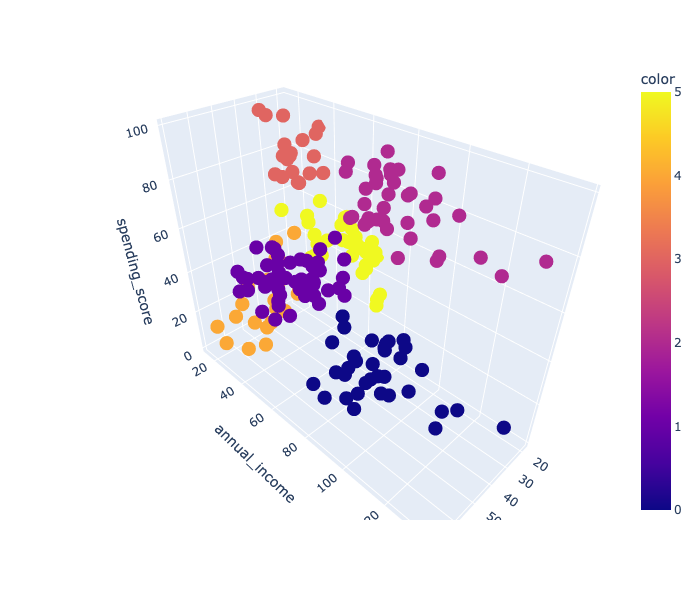

In [8]:
aglomerative_pred = pd.Series(AgglomerativeClustering(n_clusters=6).fit_predict(X), name='aglo_clust_pred')

get_3d_visualization(X, clust_res=aglomerative_pred).show('png')

[↑ contents](#contents)

<h3 id='silhouettegraph'>График силуэта</h3>

Итак, кластеры разделились хорошо.

Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров.  
`Совпадает ли это число с тем, что мы подобрали, используя дендрограмму?`

Ответ: да, 6 кластеров.

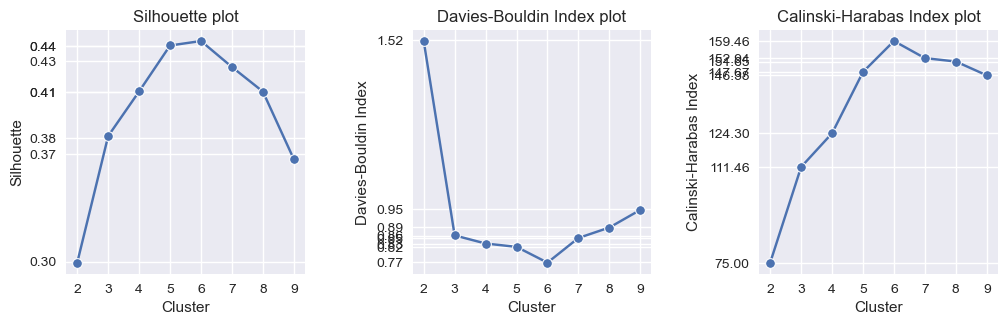

In [9]:
inertia_silhouette_plot(X, alg=AgglomerativeClustering(), coef='s+db+ch', figsize=(10, 3)).show()

Как видим, на каждом из графиков пик коэффициента находится на значении 6 (у Дэвиса-Болдина пик направлен вниз). Таким образом, оптимальное количество кластеров = 6.

[↑ contents](#contents)

<h3 id='choosemetric'>Проверка метрикой</h3>

Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами.

`Какую метрику вы будете использовать?`

Ответ: Метрику полноты.

In [10]:
print(completeness_score(labels_true=cust_df['cluster'], labels_pred=aglomerative_pred))

0.9012847747610448


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа

[↑ contents](#contents)

<h3 id='kmeansclust'>K-Means кластеризация</h3>

И напоследок выполню `K-Means` кластеризацию ради удовольствия.

Чтобы выполнить кластеризацию `K-Means`, нам надо определить оптимальное количество кластеров. Для этого посмотрим на несколько графиков, которые помогают это сделать. Проверку буду выполнять на стандартизированных данных.

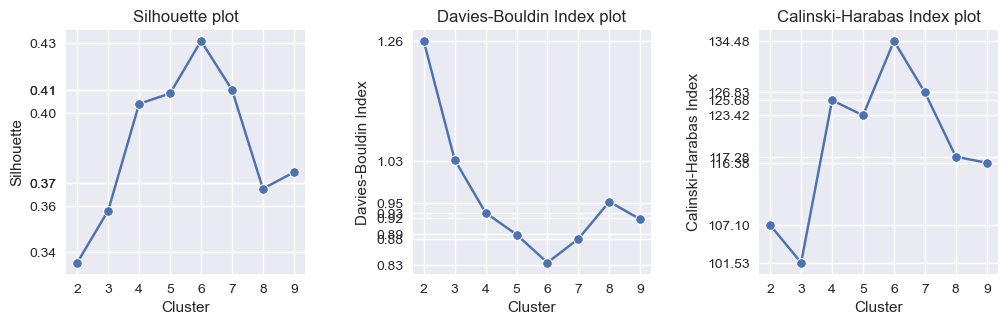

In [11]:
inertia_silhouette_plot(X=X_scaled, alg=KMeans(n_init='auto', random_state=42), coef='s+db+ch', figsize=(10, 3)).show()

Все 3 графика говорят, что нам необходимо взять 6 кластеров.  

Взглянем на диаграмму рассеяния с подсветкой кластеров:

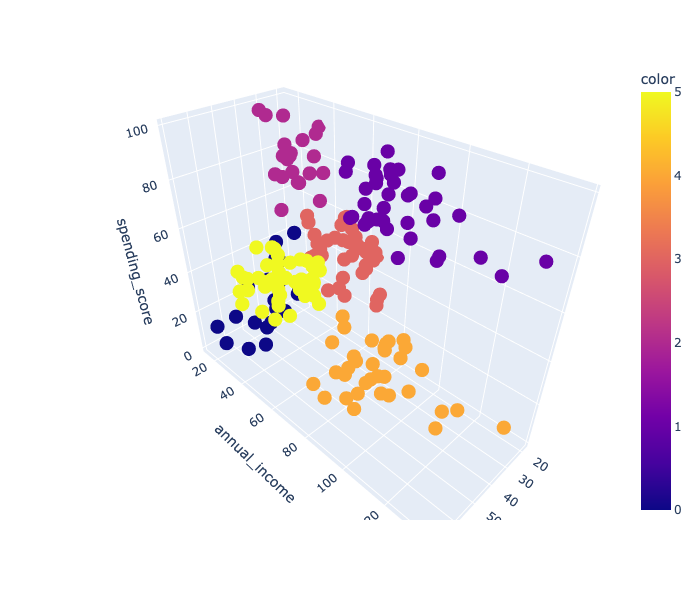

In [12]:
kmeans_alg = KMeans(n_init='auto', init='random', n_clusters=6, random_state=42).fit(X)
kmeans_cluster_pred = pd.Series(kmeans_alg.predict(X))

get_3d_visualization(X, clust_res=kmeans_cluster_pred).show('png')

Очень похоже на правду. Как и у агломеративной кластеризации. Но есть 1 нюанс.

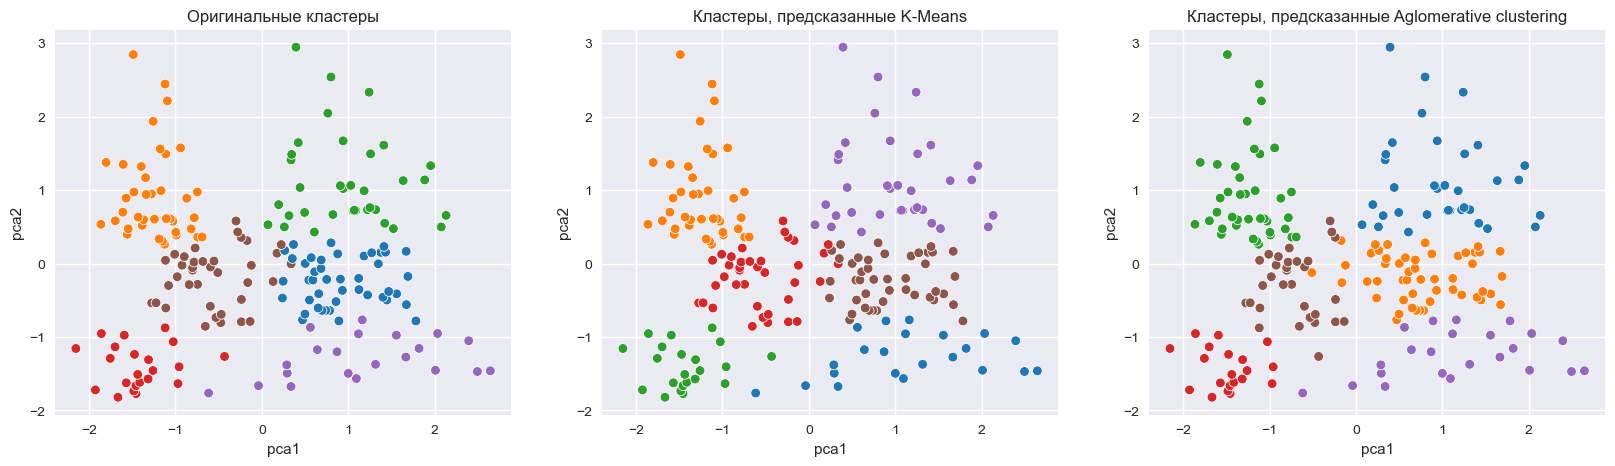

In [13]:
test_df = cust_df.copy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
test_df['pca1'], test_df['pca2'] = X_pca[:, 0], X_pca[:, 1]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

sns.scatterplot(data=test_df, x='pca1', y='pca2', hue='cluster', palette='tab10', ax=ax[0], legend=False)
sns.scatterplot(data=test_df, x='pca1', y='pca2', hue=kmeans_cluster_pred, palette='tab10', ax=ax[1], legend=False)
sns.scatterplot(data=test_df, x='pca1', y='pca2', hue=aglomerative_pred, palette='tab10', ax=ax[2], legend=False)

ax[0].set_title('Оригинальные кластеры')
ax[1].set_title('Кластеры, предсказанные K-Means')
ax[2].set_title('Кластеры, предсказанные Aglomerative clustering')

plt.show()

`K-Means` справился лучше!)

Полнота оригинала и предсказания: 0.9863613573690577
Гомогенность оригинала и предсказания: 0.9884064449362676

Матрица соответствия кластеров:


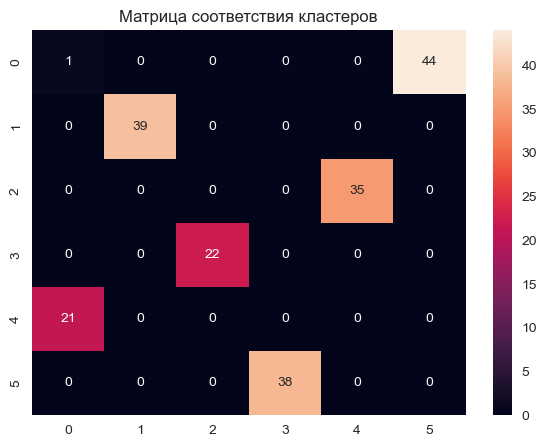

In [14]:
print(f"Полнота оригинала и предсказания: {completeness_score(cust_df['cluster'], kmeans_cluster_pred)}")
print(f"Гомогенность оригинала и предсказания: {homogeneity_score(cust_df['cluster'], kmeans_cluster_pred)}\n")
print('Матрица соответствия кластеров:')

fig, ax = plt.subplots(figsize=(7, 5))
conf_mat = confusion_matrix(cust_df['cluster'], kmeans_cluster_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')
ax.set_title('Матрица соответствия кластеров')
plt.show()

Видимо, оригинал был создан с помощью алгоритма `K-Means`, а я его тут повторил.  

Можно ещё сделать в предсказании такие же кластеры, как в оригинале:

,Оригинал,Предсказание
0.0,45,44
1.0,39,39
2.0,35,35
3.0,22,22
4.0,21,22
5.0,38,38


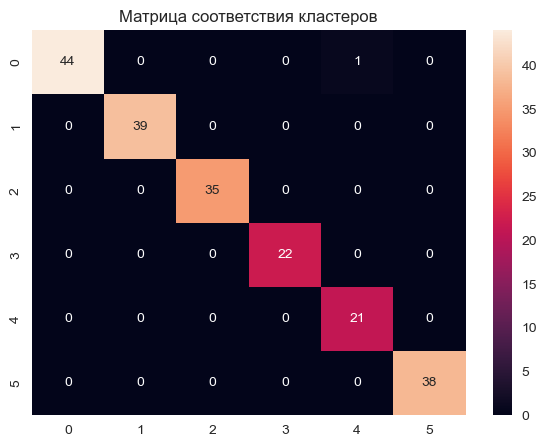

In [15]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(-conf_mat)

mapping = {col: row for row, col in zip(row_ind, col_ind)}

kmeans_cluster_pred_fixed = kmeans_cluster_pred.map(mapping)

##################################

display(pd.DataFrame([cust_df['cluster'].value_counts().sort_index(), 
                      kmeans_cluster_pred_fixed.value_counts().sort_index()], 
                     index=['Оригинал', 'Предсказание']).T)

fig, ax = plt.subplots(figsize=(7, 5))
conf_mat_fix = confusion_matrix(cust_df['cluster'], kmeans_cluster_pred_fixed)
sns.heatmap(conf_mat_fix, annot=True, fmt='d')
ax.set_title('Матрица соответствия кластеров')
plt.show()

Спасибо за просмотр.

[↑ contents](#contents)